In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (7.0, 10.0)

/Users/markshilton/anaconda/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [21]:
files = {'f': ('Results_07_Vallnord.pdf', open('Results_07_Vallnord.pdf', 'rb'))}
response = requests.post("https://pdftables.com/api?key=d1n7ydhafd5t&format=xlsx-single", files=files)
response.raise_for_status() # ensure we notice bad responses
with open("Results_07_Vallnord_RAW.xlsx", "wb") as f:
    f.write(response.content)
    
print("PDF processed to Excel")

PDF processed to Excel


In [2]:
def parse_time(raw_time):
    '''Parse the raw time strings into timedeltas for doing arithmetic on the times'''
    if raw_time == '' or None:
        return None
    else:
        try:
            dt = datetime.datetime.strptime(str(raw_time), '%M:%S.%f')
            timedelta = datetime.timedelta(minutes=dt.minute, seconds=dt.second, microseconds=dt.microsecond)
            return timedelta
        except:
            dt = datetime.datetime.strptime(str(raw_time), '%S.%f')
            timedelta = datetime.timedelta(seconds=dt.second, microseconds=dt.microsecond)
            return timedelta


def timedeltaToString(rawTd):
    '''Convert timedelta to a MM:SS.000 formatted string'''
    try:
        dt = str(rawTd)[-12:-3]
        return dt
    except:
        return None

In [3]:
def processResults(df):
    '''Calculate split times, time gaps and rankings for each rider'''
    #Apply the time parser to the raw times
    for i in range(1,6):
        df['split' + str(i)] = df['split' + str(i)].apply(parse_time)

    #Calculate the total sector times for each split
    df['sector1'] = df['split1']
    df['sector2'] = df['split2'] - df['split1']
    df['sector3'] = df['split3'] - df['split2']
    df['sector4'] = df['split4'] - df['split3']
    df['sector5'] = df['split5'] - df['split4']

    #Calculate the time gaps and rankings for everything
    cols = ['sector1', 'sector2', 'sector3','sector4', 'sector5', 'split1', 'split2', 'split3','split4', 'split5']

    for col in cols:
        df[col + 'Gap'] = df[col].apply(lambda x: (x - df[col].min())/np.timedelta64(1,'s'))
        df[col + 'Rank'] = df[col].rank().astype(int)
        df[col] = df[col].apply(timedeltaToString)
        df[col + 'Rank']

    return df

In [32]:
df = pd.read_excel('Results_07_Vallnord.xlsx')
df.reset_index(inplace=True)
cols = ['Index',
        'Rank', 
        'P', 
        'Bib', 
        'UCI Code', 
        'Name', 
        'speed',
        'speed pos',
        'split1', 
        'Pos 1 & 2', 
        'split3',
        'Pos 3 & 4',
        'split5',
        'Gap',
        'Pts']

df.head()
df.columns = cols
df['split2'] = df['split1'].shift(-2)
df['split4'] = df['split3'].shift(-2)
df['Team'] = df['Name'].shift(-2)
df['split5'] = df['split5'].shift(-1)
df['speed'] = df['speed'].shift(-1)

df2 = df.iloc[::3, :][['Rank','Name','Team','split1', 'split2','split3','split4','split5']]
df2.head()


,Rank,Name,Team,split1,split2,split3,split4,split5
0,1.0,HART Danny,MS MONDRAKER TEAM,1:29.396,2:14.803,3:09.628,3:32.692,4:13.611
3,2.0,MINNAAR Greg,SANTA CRUZ SYNDICATE,1:30.262,2:16.614,3:12.913,3:35.848,4:16.409
6,3.0,BRUNI Loic,SPECIALIZED GRAVITY POWERED BY SRAM,1:30.804,2:17.254,3:13.569,3:37.008,4:16.995
9,4.0,FAYOLLE Alexandre,POLYGON UR,1:30.456,2:17.969,3:14.204,3:37.627,4:18.933
12,5.0,FEARON Connor,KONA FACTORY TEAM DH,1:30.306,2:17.359,3:13.852,3:38.102,4:19.176


In [33]:
df = processResults(df2)
df.head()

,Rank,Name,Team,split1,split2,split3,split4,split5,sector1,sector2,...,split1Gap,split1Rank,split2Gap,split2Rank,split3Gap,split3Rank,split4Gap,split4Rank,split5Gap,split5Rank
0,1.0,HART Danny,MS MONDRAKER TEAM,01:29.396,02:14.803,03:09.628,03:32.692,04:13.611,01:29.396,00:45.407,...,0.000,1,0.000,1,0.000,1,0.000,1,0.000,1
3,2.0,MINNAAR Greg,SANTA CRUZ SYNDICATE,01:30.262,02:16.614,03:12.913,03:35.848,04:16.409,01:30.262,00:46.352,...,0.866,4,1.811,2,3.285,2,3.156,2,2.798,2
6,3.0,BRUNI Loic,SPECIALIZED GRAVITY POWERED BY SRAM,01:30.804,02:17.254,03:13.569,03:37.008,04:16.995,01:30.804,00:46.450,...,1.408,8,2.451,4,3.941,3,4.316,3,3.384,3
9,4.0,FAYOLLE Alexandre,POLYGON UR,01:30.456,02:17.969,03:14.204,03:37.627,04:18.933,01:30.456,00:47.513,...,1.060,6,3.166,8,4.576,6,4.935,4,5.322,4
12,5.0,FEARON Connor,KONA FACTORY TEAM DH,01:30.306,02:17.359,03:13.852,03:38.102,04:19.176,01:30.306,00:47.053,...,0.910,5,2.556,5,4.224,4,5.410,5,5.565,5


In [24]:
df.to_csv('07_Vallnord_Men.csv')

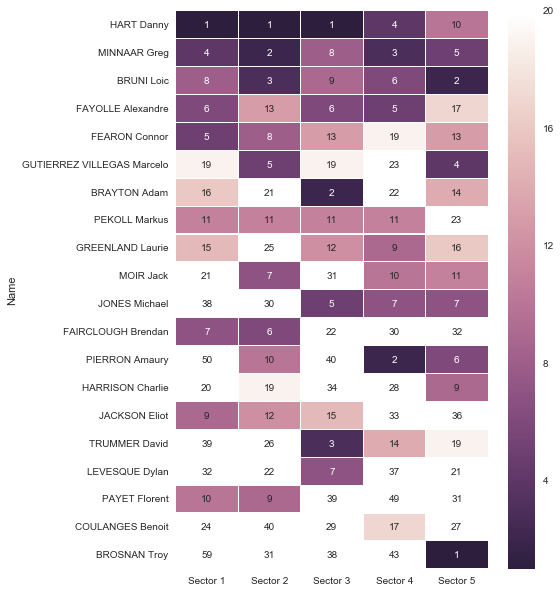

In [26]:
df_heatmap = df[df['split5Rank'] <= 20][['Name', 'split5Rank','sector1Rank', 'sector2Rank', 'sector3Rank', 'sector4Rank', 'sector5Rank']].sort_values('split5Rank')
cols = ['Name', 'Final', 'Sector 1', 'Sector 2', 'Sector 3', 'Sector 4', 'Sector 5']
df_heatmap.columns = cols
df_heatmap = df_heatmap[['Name', 'Sector 1', 'Sector 2', 'Sector 3', 'Sector 4', 'Sector 5']]
df_heatmap = df_heatmap.set_index('Name')
df_heatmap.head()

cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d", linewidths=.1, vmin=1, vmax=20, cmap=cmap)
heatmap.figure.savefig('vallnord_heatmap.png', bbox_inches='tight')

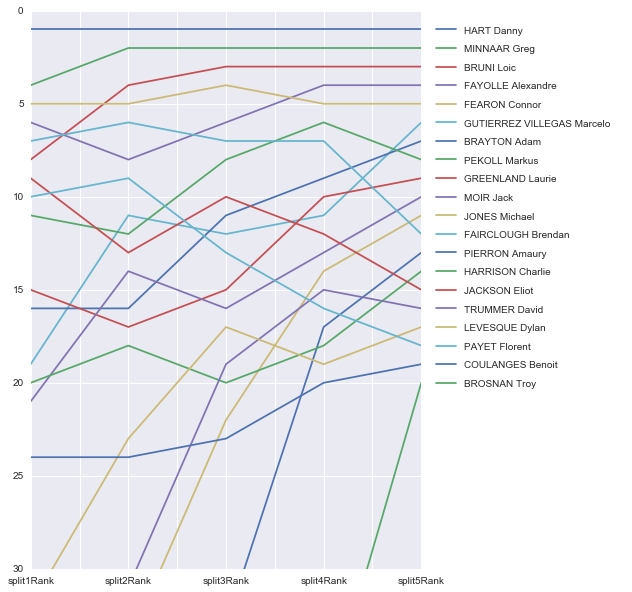

In [31]:
df_splittimes = df[df['split5Rank'] <= 20][['Name', 'split1Rank','split2Rank', 'split3Rank', 'split4Rank', 'split5Rank']]
df_splittimes = df_splittimes.set_index('Name')
df_splittimes = df_splittimes.T

sns.set_style("darkgrid")
df_splittimes.plot()
axes = plt.gca()
axes.set_ylim([0,30])
axes.invert_yaxis()
plt.legend(bbox_to_anchor=(1, 1), labelspacing=0.96, borderpad=1.5, loc=2, borderaxespad=0.)
plt.savefig('vallnord_positiontracker.png', bbox_inches='tight')

In [29]:
groups = ['split1', 'split2', 'split3','split4','split5','sector1', 'sector2', 'sector3','sector4','sector5']

for group in groups:
    segment = df[['Name', group + 'Rank', group, group + 'Gap']].sort_values(group + 'Rank', ascending=True)[:20]
    cols = ['Name', 'Position', 'Time', 'Gap']
    segment.columns = cols
    segment.to_json(group + '.json', orient='records')

print("json for d3 plots created successfully!")

json for d3 plots created successfully!


In [71]:
df[df['Name'] == "GWIN Aaron"].iloc[0]

Rank                   55
Name           GWIN Aaron
Team           THE YT MOB
split1          01:36.762
split2          02:26.685
split3          03:26.183
split4          03:53.129
split5          04:35.710
sector1         01:36.762
sector2         00:49.923
sector3         00:59.498
sector4         00:26.946
sector5         00:42.581
sector1Gap          7.366
sector1Rank            75
sector2Gap          4.516
sector2Rank            68
sector3Gap          4.673
sector3Rank            66
sector4Gap          4.097
sector4Rank            64
sector5Gap          3.249
sector5Rank            40
split1Gap           7.366
split1Rank             75
split2Gap          11.882
split2Rank             70
split3Gap          16.555
split3Rank             69
split4Gap          20.437
split4Rank             63
split5Gap          22.099
split5Rank             55
Name: 162, dtype: object